In [1]:
# Final Project - Machine Learning - Task 1
# Perform unsupervised learning- clustering and segment cutomers using UCI online retail dataset (2009-2011)
# In Task 2 we are building a predictive model for churn analysis
# So we decided to take data of 1.5 years duration for RFM analysis and clustering and to Create archetypes that represent different customer segments
# And take the other 6 months purchase data to create the target variable (churn or not)  for our churn prediction model 
# Motivation from 
# Y. Aleksandrova, “APPLICATION OF MACHINE LEARNING FOR CHURN PREDICTION BASED ON TRANSACTIONAL DATA (RFM ANALYSIS),”
# International Multidisciplinary Scientific GeoConference SGEM ..., Jun. 2018, doi: 10.5593/sgem2018/2.1/s07.016.

# Authors
# Jeevanthi Panawala
# Sreedharani

In [1]:
# Library Imports
import pandas as pd
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples

In [2]:
#----------------------- Load Dataset---------------------------------------------------------------------------#
# Dataset - A real online retail transaction data set of two years (2009-2011)
df_sheet1=pd.read_excel("../Data/online_retail_II.xlsx",sheet_name=0) # 2009-2010
df_sheet2=pd.read_excel("../Data/online_retail_II.xlsx",sheet_name=1) # 2010-2011

# Combine the two datasets
df = pd.concat([df_sheet1,df_sheet2],ignore_index=True)

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
#-------------------------------Exploratory Data Analysis and Data Cleaning------------------------------------------------------#

In [4]:
df.shape

(1067371, 8)

In [5]:
# Check for missing values in the dataset
print(df.isnull().sum())

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64


In [12]:
# There are missing values in CustomerID and Description columns.
# Eventhough the CustomerID and description are not important for customer segmentation
# They are required for our further analysis
# and They cannot be imputed
# Imputing nominal values with mode is meaningless in the context of this dataset
# So it was decided to drop the rows with the missing values

In [4]:
#--------------------- Dropping the missing values --------------------------------------------------#
df = df.dropna(subset=['Customer ID', 'Description'])

In [7]:
#------------Check the missing values again------------#
print(df.isnull().sum())

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64


In [5]:
#---------- Now the dataset does not have any missing values -----------------------------#
#----------- Check the size of the dataset after clearing the missing values--------------#
df.shape

(824364, 8)

In [9]:
# Explore from which countries, the orders have been placed
top_countries= df['Country'].value_counts().head(10)
print(top_countries)

Country
United Kingdom    741301
Germany            17624
EIRE               16195
France             14202
Netherlands         5140
Spain               3811
Belgium             3123
Switzerland         3064
Portugal            2504
Australia           1913
Name: count, dtype: int64


In [25]:
# It seems that 90% of the orders have come from UK. 
# All the top countries are Europian, except Austrailia
# This may be becuase it's a UK based company

In [15]:
# Exploring the customer distribution.
# How many unique customers are there?
df['Customer ID'].unique().shape

(5942,)

In [27]:
# There are 5942 unique customers

In [16]:
# Now we are exploring the cumulative percentages of the orders made by the top customers
((df['Customer ID'].value_counts()/sum(df['Customer ID'].value_counts()))*100).head(n=20).cumsum()

Customer ID
17841.0     1.588740
14911.0     2.997462
12748.0     3.883843
14606.0     4.697682
14096.0     5.319737
15311.0     5.891936
14156.0     6.392928
14646.0     6.864807
13089.0     7.281856
16549.0     7.676706
14298.0     8.024610
14527.0     8.368755
17850.0     8.711686
15039.0     9.052554
15005.0     9.361641
13081.0     9.656414
17511.0     9.915280
13263.0    10.148187
16782.0    10.378668
14159.0    10.607329
Name: count, dtype: float64

In [12]:
# From the resulting list, we can see that 17 top customers contrinute to the 10% of the total orders

In [29]:
#-------Exploring the quality of product details------------#

In [17]:
df['StockCode'].unique().shape

(4646,)

In [18]:
df['Description'].unique().shape

(5299,)

In [27]:

# There is a mismatch in the number of unique values for stock code and description. 
# There may be duplicate descriptions for the same stock code.
# We are exploring these duplications

# Group by StockCode and collect all unique descriptions
#grouped_descriptions = df.groupby('StockCode')['Description'].unique()

# Filter StockCodes with more than one unique description
# duplicates = grouped_descriptions[grouped_descriptions.apply(len) > 1]

# Print the duplicate descriptions for each StockCode
#print("StockCodes with duplicate descriptions:")
#for stockcode, descriptions in duplicates.items():
    #print(f"StockCode: {stockcode}")
    #print(f"Descriptions: {list(descriptions)}\n")

In [28]:
# There are many duplicate descriptions for several stock codes. The reason seems to be spelling differences. 
# This affects the quality of the dataset
# As we are focusing on Customer segmentation and the numerical values such as quantity and price are more important in our analysis,
# We decided to rectify the issues related to the quantity and price.


In [10]:
#-------------- Get the summary statistics for Quantity and Price -------------------------#
print(df.Quantity.describe())

count    824364.000000
mean         12.414574
std         188.976099
min      -80995.000000
25%           2.000000
50%           5.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64


In [20]:
print(df.Price.describe())

count    824364.000000
mean          3.676800
std          70.241388
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max       38970.000000
Name: Price, dtype: float64


In [31]:
# Quantity has negative values. This implies that there are purchase returns in the data set. 
# We decided to remove the transactions with negative vakues for quantity
# and keep the matching buying transaction of the purchase return, 
# because it gives some important information about customer's buying patterns

In [6]:
# Remove rows where Quantity has negative values
df = df[df['Quantity'] >= 0]
df.shape

(805620, 8)

In [6]:
print(df.Quantity.describe())

count    805620.000000
mean         13.307665
std         144.306739
min           1.000000
25%           2.000000
50%           5.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64


In [7]:
# Save the refined dataset for future use
df.to_csv('../Data/refined_data.csv', index=False)

In [ ]:
#------------------ Filter Data from 2009 t0 2011 May For Clustering---------------------------#

In [7]:
filter_date=pd.to_datetime('2011-06-01')
df = df[df['InvoiceDate'] < filter_date]
df.shape

(553158, 8)

In [13]:
print(df['InvoiceDate'].describe())

count                           553158
mean     2010-09-03 18:43:09.101666304
min                2009-12-01 07:45:00
25%                2010-05-05 16:12:00
50%                2010-09-27 12:21:00
75%                2010-12-08 09:20:00
max                2011-05-31 15:41:00
Name: InvoiceDate, dtype: object


In [ ]:
#----------------------------------------------Starting Customer Segmentation-------------------------------------------------#

In [26]:
#-----------------------------------------------RFM Model------------------------------------------------------------------#
# For segmenting customers, we need to assign a value to each customer
# To calculate this value we are going with popular RFM model used in Marketing
# Recency - how recently a customer purchased
# Frequency - how frequent the customer buys
# Monetary value - The total value of the orders that customer has placed

In [8]:
# For the monetary value, we need to calcuate the amount of the purchase
# So we are adding a new column called "Amount"
df["Amount"]=df["Quantity"]*df["Price"]

In [9]:
df.shape # Checking the number of columnns

(553158, 9)

In [16]:
df.head() # Checking the data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [17]:
print(df["InvoiceDate"].max())

2011-05-31 15:41:00


In [10]:
#-------------------------------------- Calculating Recency-------------------------------------------------------------------------------#
# Reference Date - The most recent Invoice Date in the Dataset. We add 1 day to the reference date to avoind 0 recency for the reference date
reference_date = df["InvoiceDate"].max() + timedelta(days=1)

# A column Days_Since_Last_Purchase is introduced to the dataset
# Days_Since_Last_Purchase= No of Days Before the Reference Date, which the customer put an order
df["Days_Since_Last_Purchase"]=(reference_date-df["InvoiceDate"]).dt.days
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount,Days_Since_Last_Purchase
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,547
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,547
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,547
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,547
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,547


In [11]:
# Group the transactions by CustomerID and Calculate the recency from each customer's last purchase

recency_df = df.groupby("Customer ID").agg(
    Recency=("Days_Since_Last_Purchase", "min")  # Find the minimum days since the last purchase for each customer
).reset_index()

recency_df.head()


,Customer ID,Recency
0,12346.0,134
1,12347.0,55
2,12348.0,57
3,12349.0,216
4,12350.0,118


In [21]:
print(recency_df.Recency.describe())

count    4935.000000
mean      169.682472
std       142.022612
min         1.000000
25%        44.000000
50%       162.000000
75%       244.000000
max       547.000000
Name: Recency, dtype: float64


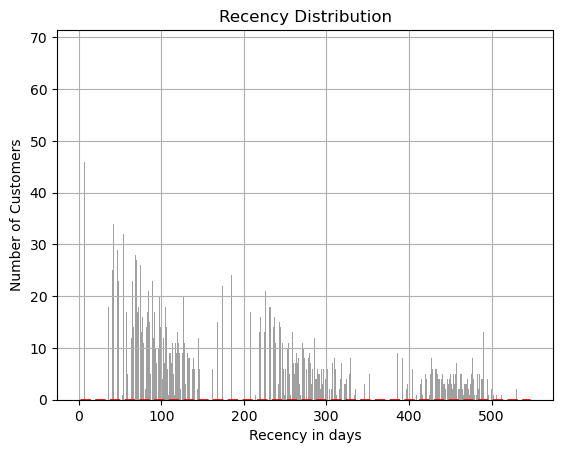

In [12]:
# Visualize the recency distribution
x=recency_df["Recency"]
recency_mean = np.mean(recency_df["Recency"])  # Calculate the mean
sigma = np.sqrt(np.var(recency_df["Recency"]))  # Calculate the standard deviation

# Plot histogram
n, bins, patches = plt.hist(x, 1000, facecolor='grey', alpha=0.75)

# Plot the normal distribution curve
y = norm.pdf(bins, recency_mean, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

# Add labels
plt.xlabel('Recency in days')
plt.ylabel('Number of Customers')
plt.title('Recency Distribution')
plt.grid(True)
plt.show()

In [73]:
# This histrogram shows that recency has a right skewed distribution
# Majority of the transactions has lesser recency and there's a uniform distribution for higher recency

In [13]:
#-----------------------Monetary Value -----------------------------------------------------------------#
monetary_value=df[['Customer ID','Amount']].groupby("Customer ID").sum().reset_index()

In [14]:
#-----------------------Frequency -----------------------------------------------------------------#
# Frequency is calculated by the number of times that a customer has placed orders
frequency=df[['Customer ID','Quantity']].groupby("Customer ID").count().reset_index()
frequency.rename(columns={'Quantity':'frequency'},inplace=True)

In [15]:
#----------- Merging Recency, Frequency and Monetary value to a single data frame-------#
rfm_df=recency_df
rfm_df=rfm_df.merge(monetary_value,how='outer')
rfm_df.head()

,Customer ID,Recency,Amount
0,12346.0,134,77556.46
1,12347.0,55,3146.75
2,12348.0,57,1709.40
3,12349.0,216,2671.14
4,12350.0,118,334.40


In [16]:
rfm_df=rfm_df.merge(frequency,how='outer')
rfm_df.head()

,Customer ID,Recency,Amount,frequency
0,12346.0,134,77556.46,34
1,12347.0,55,3146.75,155
2,12348.0,57,1709.40,48
3,12349.0,216,2671.14,102
4,12350.0,118,334.40,17


In [46]:
# Now we have prepared the RFM (Recency, Frequency and Monetary value) model for the customers
# For customer segmentation, we will be using K-means clustering algorithm
# For k-means we have to standardize the values of the variables in a way that they take a mean of 1 and varaiance of 0.
# From the RFM values we can see, that there are varying ranges in the variables. Specially in Amout(Monetray value) column
# So we decided to transform all the variables to log scale and standardize the values

In [17]:
# Adding columns to store the log values

rfm_df["Recency_Log"]=np.log1p(rfm_df['Recency'])
rfm_df["Amount_Log"]= np.log1p(rfm_df['Amount'])
rfm_df["frequency_Log"]=np.log1p(rfm_df['frequency'])
rfm_df.head()

,Customer ID,Recency,Amount,frequency,Recency_Log,Amount_Log,frequency_Log
0,12346.0,134,77556.46,34,4.905275,11.258774,3.555348
1,12347.0,55,3146.75,155,4.025352,8.054443,5.049856
2,12348.0,57,1709.40,48,4.060443,7.444483,3.891820
3,12349.0,216,2671.14,102,5.379897,7.890635,4.634729
4,12350.0,118,334.40,17,4.779123,5.815324,2.890372


In [18]:
X = rfm_df[['Recency_Log', 'Amount_Log','frequency_Log']]

In [19]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 
print(X_scaled[:5])

[[ 0.24623931  3.37127854 -0.23515605]
 [-0.46027657  0.9962038   0.89469333]
 [-0.43210073  0.5440963   0.01921727]
 [ 0.62732761  0.87478786  0.58085692]
 [ 0.14494877 -0.66344857 -0.73787875]]


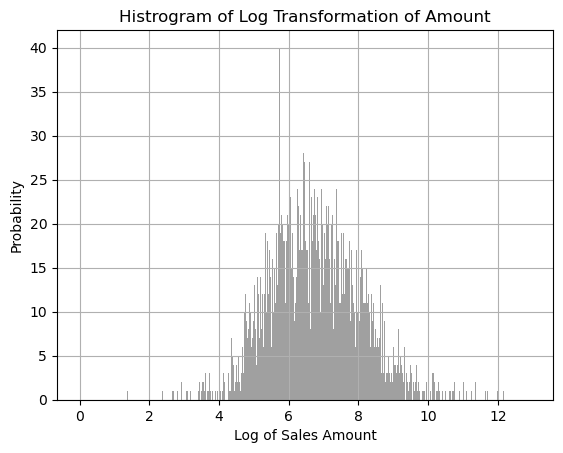

In [20]:
# Visualize the distribution of Amount_Log values to check whether it has a normal distribution after transformation
# We are checking the Amount_Log variable because it is the one with the widest range of values

x=rfm_df["Amount_Log"]

# Plot histogram
n, bins, patches = plt.hist(x, 1000, facecolor='grey', alpha=0.75)

# Add labels
plt.xlabel('Log of Sales Amount')
plt.ylabel('Probability')
plt.title('Histrogram of Log Transformation of Amount')
plt.grid(True)
plt.show()

In [ ]:
# Histrogram proves that Amount_Log has a normal distribution.

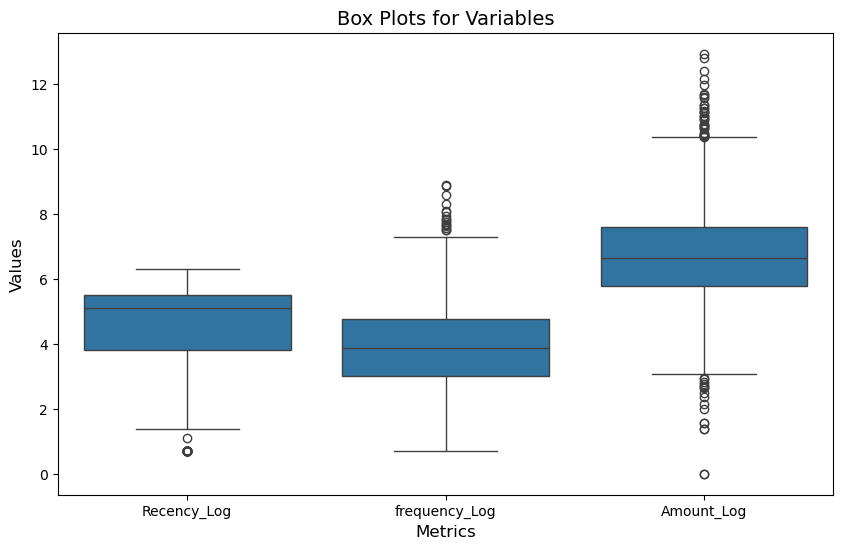

In [21]:
# Checking for outliers of R,F,M Values
# Create a DataFrame in long format for better visualization
melted_df = rfm_df[['Recency_Log', 'frequency_Log', 'Amount_Log']].melt(var_name="Metric", value_name="Value")

# Set the figure size
plt.figure(figsize=(10, 6))

# Create a boxplot
sns.boxplot(x="Metric", y="Value", data=melted_df)

# Add labels and a title
plt.title("Box Plots for Variables", fontsize=14)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Values", fontsize=12)

# Show the plot
plt.show()

In [105]:
# There are outliers in Amount and Frequency. It seems that they are not errors. 
# They are revealing some important insights like there are high-end customers spending higher amounts
# There are customers who place orders frequently

In [ ]:
#--------------------------------K-means Clustering of RFM Dataset----------------------------------------------------------#

In [ ]:
#-------------------------------- Calculating and Ploting Silhouette Scores to determine the best number of clusters--------------#

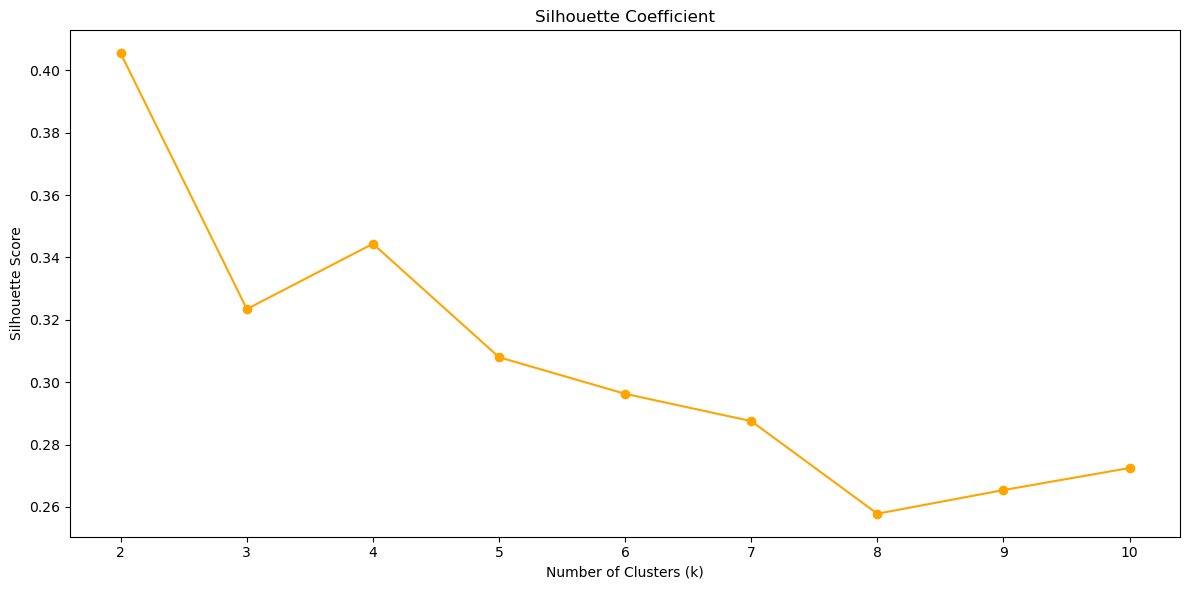

In [23]:
k_range = range(2, 11)  # Test k from 2 to 10
inertia = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)  # rfm_scaled: Scaled RFM dataframe
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))


plt.figure(figsize=(12, 6))

# Silhouette score plot

plt.plot(k_range, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Coefficient')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.savefig('figures/SilhouetteCoefficient.png', format='png')
plt.show()

In [49]:
# According to the Silhouette Coefficient plot, k=2 and k=4 give the maximum Silhoutte score.
# So it was decided to check with k=2 to k=4 for clustering and see the characteristics of the clusters
# The code support was taken from "https://scikit-learn.org/"

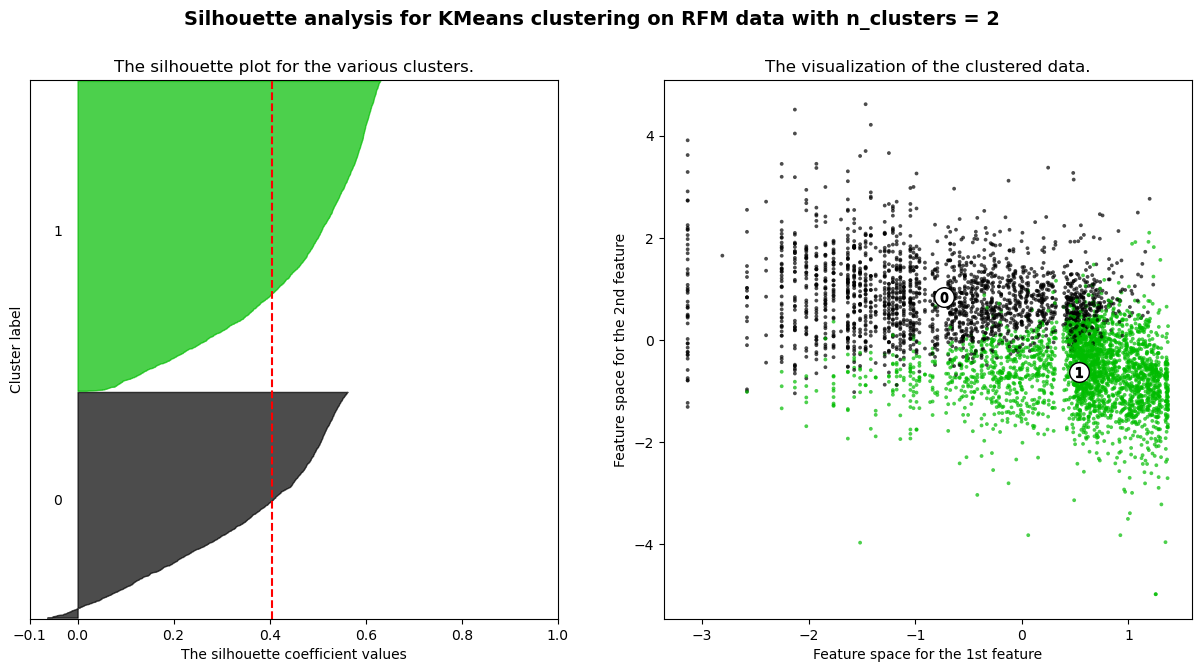

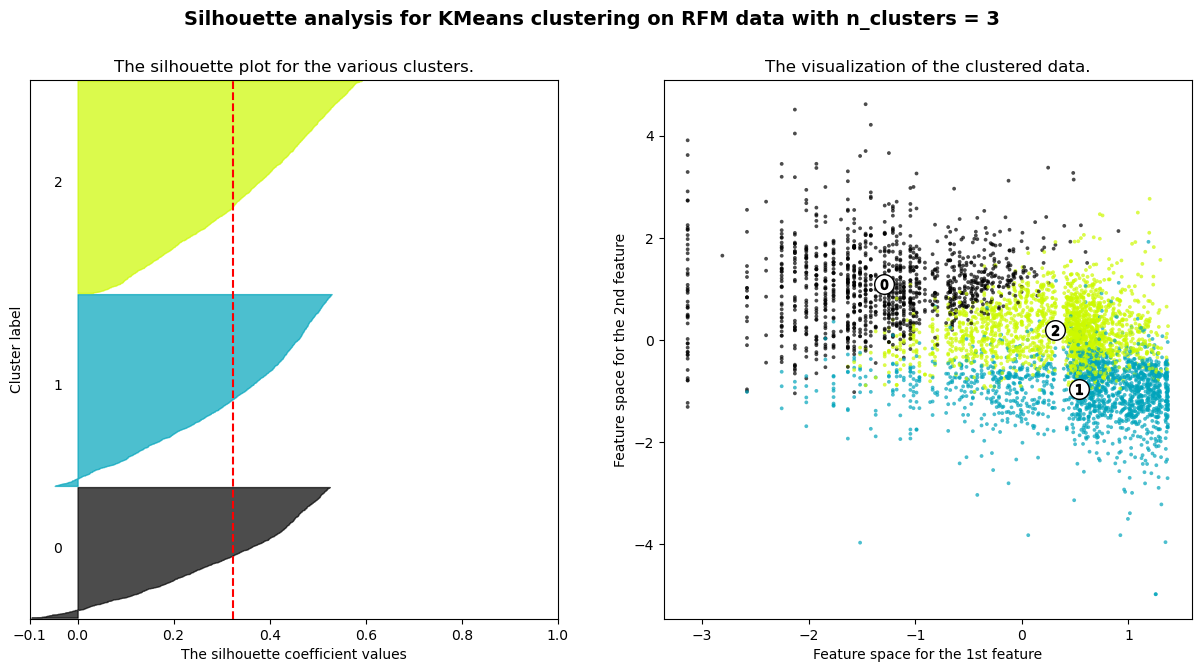

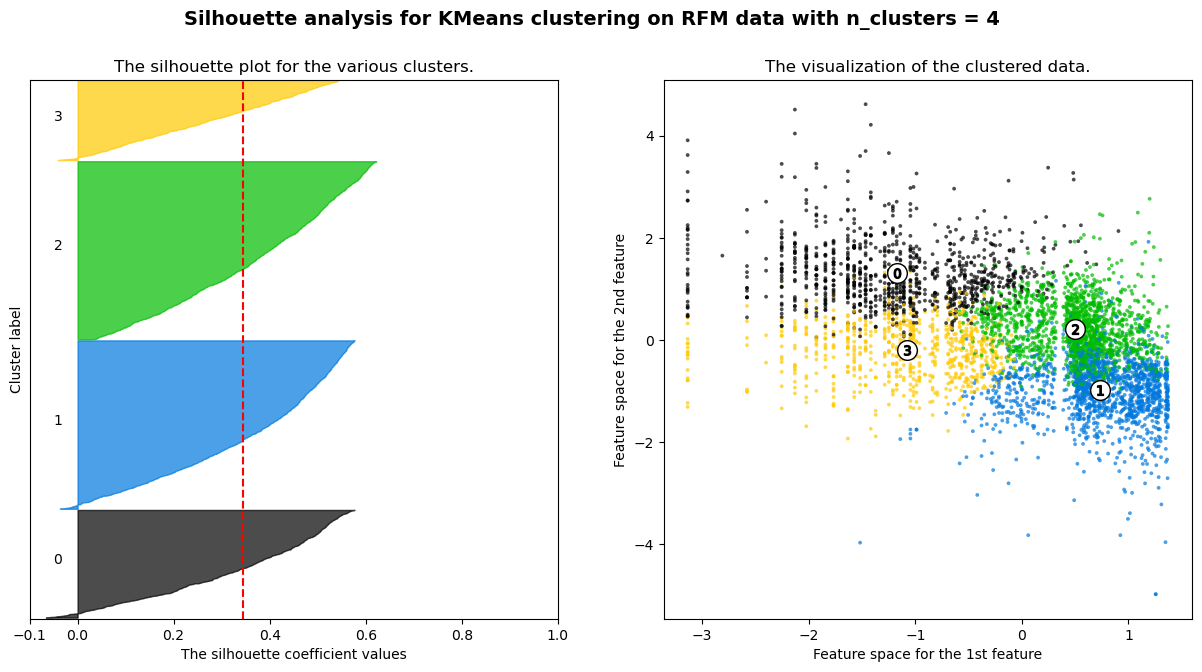

In [31]:
range_n_clusters = [2,3,4]
cluster_centers = dict()
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    cluster_centers.update({n_clusters :{
                                        'cluster_center':clusterer.cluster_centers_,
                                        'silhouette_score':silhouette_avg,
                                        'labels':cluster_labels}
                           })
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_scaled[:, 0], X_scaled[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(
        "Silhouette analysis for KMeans clustering on RFM data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
    file_name = "figures/cluster" + str(n_clusters) + ".png"
    plt.savefig(file_name, format='png')
plt.show()


In [ ]:
#Above plots show the clusters, their centers and Silhoette co-efficients of all the samples.
# All 3 clustering plots shows some overlapped samples
# So we are doing further analysis of the clusters

In [ ]:
#----------------- Cluster Analysis ---------------------------------------------------------------------#

In [32]:
# Printing the cluster center values of Recency, Amount and Frequency for number of clusters= 2 ,3 and 4
# First the log values are converted to the origininal values and scaling was reverted

feature_vector = ['Recency_Log','Amount_Log','frequency_Log']
for i in (2,3,4):
    print("for {} number of clusters".format(i))
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=feature_vector))
    print("Silhouette score for cluster {} is {}". format(i, cluster_centers[i]['silhouette_score']))
    print()

for 2 number of clusters
   Recency_Log   Amount_Log  frequency_Log
0    40.129785  2564.360075     144.608248
1   192.608423   357.270816      21.272785
Silhouette score for cluster 2 is 0.40479809638719344

for 3 number of clusters
   Recency_Log   Amount_Log  frequency_Log
0    19.787918  3556.965954     187.068694
1   194.670038   227.009004      12.843202
2   146.393870  1061.195957      67.423837
Silhouette score for cluster 3 is 0.3235203293255856

for 4 number of clusters
   Recency_Log   Amount_Log  frequency_Log
0    23.103760  4815.979945     251.520055
1   248.651699   218.616282      12.544940
2   184.017233  1108.336601      72.013905
3    25.890676   622.159651      33.735010
Silhouette score for cluster 4 is 0.3445391380879003



In [72]:
# From these cluster center values, we can have following insights.
# In 2 clusters, we can identify two classes of customers 
# Who spends more money and buy frequently
# Who spends low amount money and they are also less frequent buyers

# In 3 clusters,
# High end customers who buy frequently and who have bought recently
# Customers with medium value purchases and with medium frequency and the recency is high
# Low end customers who rarely buys and has not recently purchased

# In 4 clusters,
# We can identify 4 types customers
# High end, frequent buyers and recent shoppers - They are loyal customers
# High end, moderately frequent buyers but they haven't shopped recently
# Medium, recent and moderately frequent shoppers
# Low end, less frequent and old buyers - They are long lost customers

# Even if Silhoette score value is better for two number of clusters
# Four number of clusters give us more clear insights about the customers
# The insights provided by 4 clusters seems more useful to make data driven decisions

#--------------------------------------------Archetypes--------------------------------------------------------------------------------------------#
# Cluster                         Archetype
# 0         Loyal Luxury Customers who have shopped recently
# 1         Long lost Rare Shoppers who Spend very little
# 2         Luxury Customers who used to shop frequently but they have stopped purchasing
# 3         Moderate Recent Buyers

#------------------------------------------------------------------------------------------------------------------------------------------------#

# The retail company needs to work on their marketing to retain loyal luxury customers (cluster 1), 
# Convert moderate recent buyers (cluster 3) into Loyal Luxury Buyers
# Target lost Luxury Buyers (cluster 2 ) to regain them
# Cluster 1 is long lost and they are a little importance as they are not spending much

In [33]:
# Label the data with archetypes
labels = cluster_centers[4]['labels']
rfm_df['Cluster'] = labels
rfm_df.head()

,Customer ID,Recency,Amount,frequency,Recency_Log,Amount_Log,frequency_Log,Cluster
0,12346.0,134,77556.46,34,4.905275,11.258774,3.555348,0
1,12347.0,55,3146.75,155,4.025352,8.054443,5.049856,0
2,12348.0,57,1709.40,48,4.060443,7.444483,3.891820,2
3,12349.0,216,2671.14,102,5.379897,7.890635,4.634729,2
4,12350.0,118,334.40,17,4.779123,5.815324,2.890372,1


In [34]:
# Add archetype as a column
# Define the mapping of cluster labels to archetypes
cluster_to_archetype = {
    0: "Loyal Luxury Shoppers",
    1: "Long Lost Rare Shoppers",
    2: "Lost Luxury Shoppers ",
    3: "Moderate Recent Shoppers"
}

# Map cluster labels to archetype names
rfm_df['Archetype'] = rfm_df['Cluster'].map(cluster_to_archetype)
rfm_df.head()

,Customer ID,Recency,Amount,frequency,Recency_Log,Amount_Log,frequency_Log,Cluster,Archetype
0,12346.0,134,77556.46,34,4.905275,11.258774,3.555348,0,Loyal Luxury Shoppers
1,12347.0,55,3146.75,155,4.025352,8.054443,5.049856,0,Loyal Luxury Shoppers
2,12348.0,57,1709.40,48,4.060443,7.444483,3.891820,2,Lost Luxury Shoppers
3,12349.0,216,2671.14,102,5.379897,7.890635,4.634729,2,Lost Luxury Shoppers
4,12350.0,118,334.40,17,4.779123,5.815324,2.890372,1,Long Lost Rare Shoppers


In [37]:
rfm_df.shape

(4935, 9)

In [48]:
# Save the segmented data into a csv file to be used for churn risk prediction
rfm_df.to_csv('../Data/customer_segments.csv', index=False)


In [ ]:
#-------------------------- Further Analysis of Each Cluster ( 4 Archetypes)-------------------------------------------#

In [ ]:
#------------------------- Amounts-------------------------------------------------#

C:\Users\ME\AppData\Local\Temp\ipykernel_14584\382825498.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Archetype', y='Value', data=plot_data, palette='Set2')


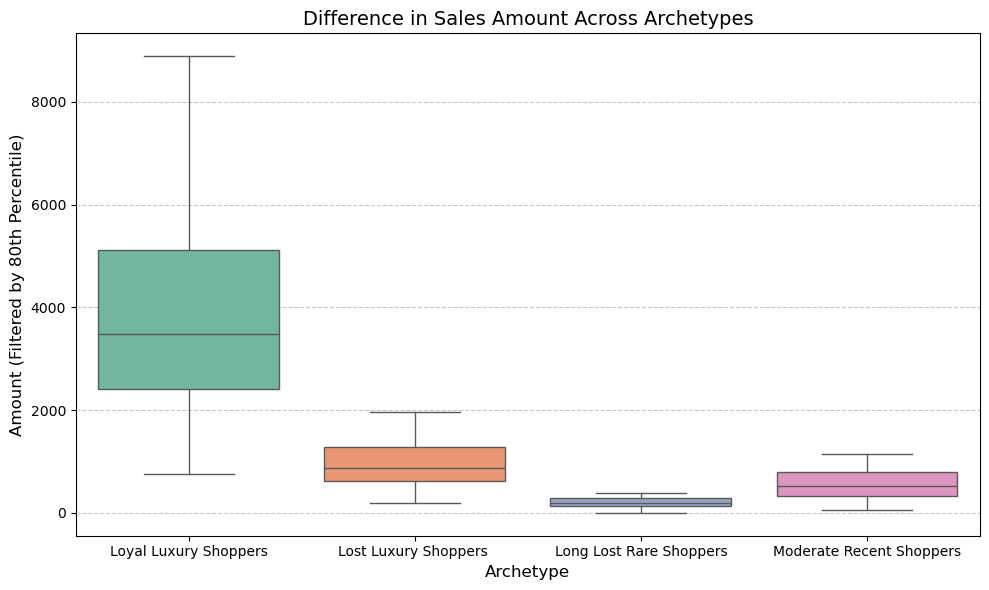

In [37]:
cutoff_quantile = 80
field_to_plot = 'Amount'

# Prepare data for each cluster
cluster_data = []
archetypes = rfm_df['Archetype'].unique()
for archetype in archetypes:
    data = rfm_df[rfm_df['Archetype'] == archetype][field_to_plot].values
    data = data[data < np.percentile(data, cutoff_quantile)]  # Filter based on quantile
    cluster_data.append(data)

# Prepare data for plotting
plot_data = pd.DataFrame({
    'Archetype': np.concatenate([[str(archetype)] * len(cluster_data[i]) for i, archetype in enumerate(archetypes)]),
    'Value': np.concatenate(cluster_data)
})

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Archetype', y='Value', data=plot_data, palette='Set2')

# Customize the plot
plt.title(f'Difference in Sales {field_to_plot} Across Archetypes', fontsize=14)
plt.xlabel('Archetype', fontsize=12)
plt.ylabel(f'{field_to_plot} (Filtered by {cutoff_quantile}th Percentile)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("figures/MonetaryDiff.png", format='png')
# Display the plot
plt.show()

C:\Users\ME\AppData\Local\Temp\ipykernel_12276\1977893079.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Archetype', y='Value', data=plot_data, palette='Set2')


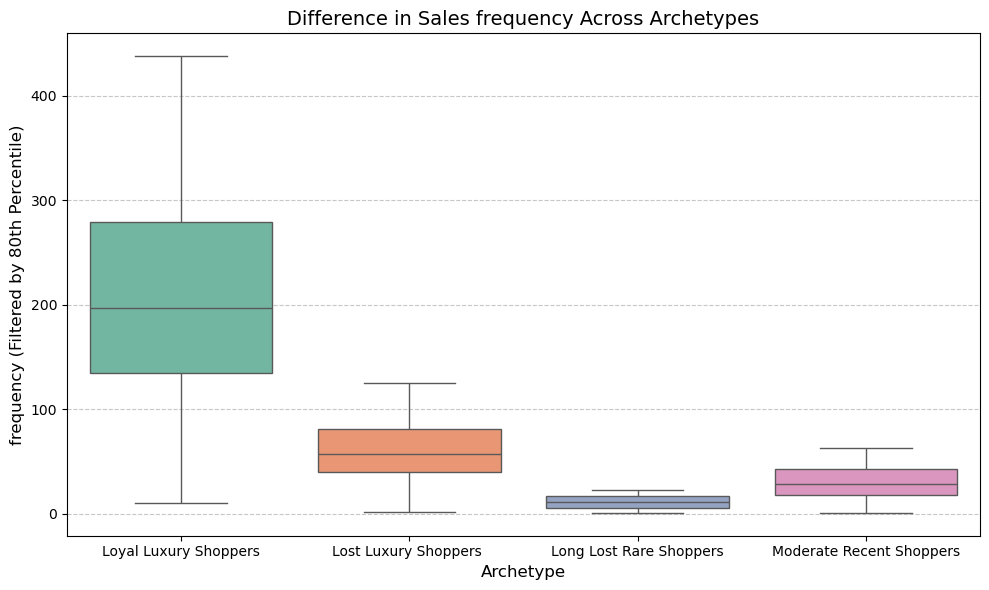

In [42]:
cutoff_quantile = 80
field_to_plot = 'frequency'

# Prepare data for each cluster
cluster_data = []
archetypes = rfm_df['Archetype'].unique()
for archetype in archetypes:
    data = rfm_df[rfm_df['Archetype'] == archetype][field_to_plot].values
    data = data[data < np.percentile(data, cutoff_quantile)]  # Filter based on quantile
    cluster_data.append(data)

# Prepare data for plotting
plot_data = pd.DataFrame({
    'Archetype': np.concatenate([[str(archetype)] * len(cluster_data[i]) for i, archetype in enumerate(archetypes)]),
    'Value': np.concatenate(cluster_data)
})

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Archetype', y='Value', data=plot_data, palette='Set2')

# Customize the plot
plt.title(f'Difference in Sales {field_to_plot} Across Archetypes', fontsize=14)
plt.xlabel('Archetype', fontsize=12)
plt.ylabel(f'{field_to_plot} (Filtered by {cutoff_quantile}th Percentile)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()

C:\Users\ME\AppData\Local\Temp\ipykernel_12276\3865249293.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Archetype', y='Value', data=plot_data, palette='Set2')


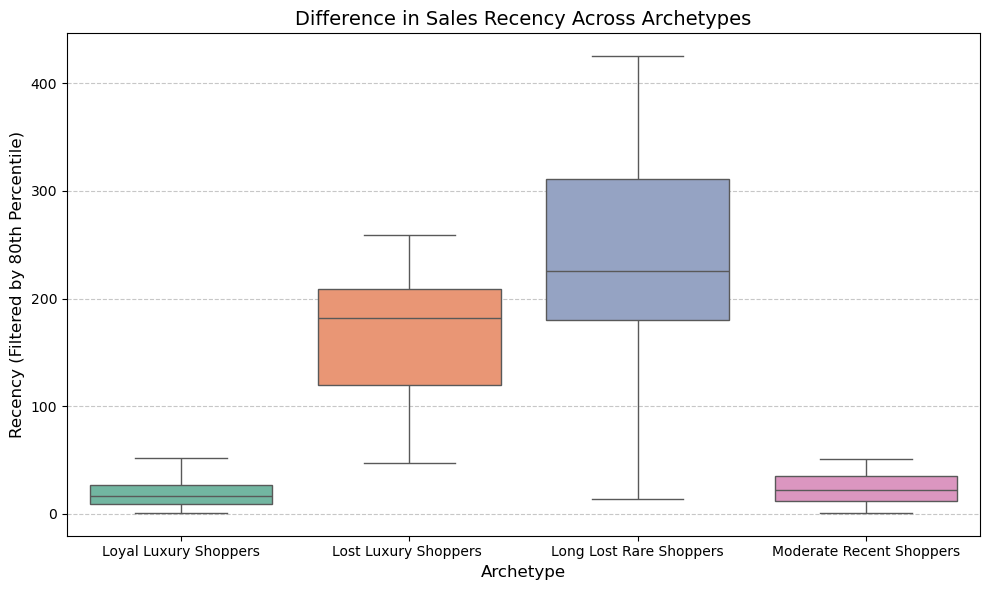

In [43]:
cutoff_quantile = 80
field_to_plot = 'Recency'

# Prepare data for each cluster
cluster_data = []
archetypes = rfm_df['Archetype'].unique()
for archetype in archetypes:
    data = rfm_df[rfm_df['Archetype'] == archetype][field_to_plot].values
    data = data[data < np.percentile(data, cutoff_quantile)]  # Filter based on quantile
    cluster_data.append(data)

# Prepare data for plotting
plot_data = pd.DataFrame({
    'Archetype': np.concatenate([[str(archetype)] * len(cluster_data[i]) for i, archetype in enumerate(archetypes)]),
    'Value': np.concatenate(cluster_data)
})

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Archetype', y='Value', data=plot_data, palette='Set2')

# Customize the plot
plt.title(f'Difference in Sales {field_to_plot} Across Archetypes', fontsize=14)
plt.xlabel('Archetype', fontsize=12)
plt.ylabel(f'{field_to_plot} (Filtered by {cutoff_quantile}th Percentile)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Display the plot
plt.show()